### Automation of Identifiability Computations

In [3]:
from sympy import *
import copy
init_printing(use_unicode=True)

In [4]:
ddt = symbols('ddt')
a = IndexedBase('a')
b = IndexedBase('b')
k = symbols('k')

In [5]:
def parametersFromEdges(edges):
    # edges = [[1 ->], [2 ->], ..., [n ->]], that is, spot i-1 in the list has a list of outgoing edges from compartment i
    n = len(edges)
    parameters = []
    for i in range(n):
        for j in edges[i]:
            parameters.append(a[j,i+1])
    return parameters

In [6]:
def compartmentalMatrix(edges):
    # edges = [[1 ->], [2 ->], ..., [n ->]]
    n = len(edges)
    A = zeros(n,n)
    for i in range(n):
        ai = []
        for j in edges[i]:
            if j!=0:
                A[i,j-1] = a[i+1,j]
            ai.append(-a[j,i+1])
        A[i,i] = sum(ai)
    return A

In [7]:
def inputOutput(A,i,j,L,leak): #A: compartmental matrix, i: input, j: output, L: distance (on graph) from i to j, leak: 1 if there are leaks, 0 if there are no leaks
    n = A.shape[0]
    dA = ddt*eye(n) - A
    dAij = copy.deepcopy(dA)
    dAij.row_del(i-1)
    dAij.col_del(j-1)
    ycoeffs = Poly(det(dA),ddt).coeffs()
    ucoeffs = Poly(det(dAij),ddt).coeffs()
    ycoeffs.remove(1)
    if L==0:
        ucoeffs.remove(1)
    return ycoeffs + ucoeffs
    print(ycoeffs,ucoeffs)
    #if leak == 1:
    #    nontrivycoeffs = ycoeffs[1:n+1]
    #if leak == 0:
    #    nontrivycoeffs = ycoeffs[1:n]
    #if L == 0:
    #    nontrivucoeffs = ucoeffs[1:n]
    #if L != 0:
    #    nontrivucoeffs = ucoeffs
    #print(nontrivycoeffs,nontrivucoeffs)

In [8]:
def modelJacobian(p,c):
    return Matrix(c).jacobian(Matrix(p))

In [9]:
def isIdentifiable(edges,i,j,L,leak):
    p = parametersFromEdges(edges)
    A = compartmentalMatrix(edges)
    c = inputOutput(A,i,j,L,leak)
    J = modelJacobian(p,c)
    return J.rank() == J.shape[1]

### Example below here!

In [72]:
A = compartmentalMatrix([[2],[0,1,3],[2,0]]) 
A

⎡-a[2, 1]            a[1, 2]                     0         ⎤
⎢                                                          ⎥
⎢a[2, 1]   -a[0, 2] - a[1, 2] - a[3, 2]       a[2, 3]      ⎥
⎢                                                          ⎥
⎣   0                a[3, 2]             -a[0, 3] - a[2, 3]⎦

In [44]:
c = inputOutput(A,1,1,0,1)
c

In [10]:
c2 = poly(c[0]) #ci/di is the coefficient of ith derivative of y/u
c1 = poly(c[1])
c0 = poly(c[2])
d1 = poly(c[3])
d0 = poly(c[4])

In [11]:
x = (b[0,1]-(k-1)*b[2,1],b[0,3]+b[1,2]*(k-1)/k,b[1,2]/k,k*b[2,1],b[2,3]+b[1,2]/k,b[3,2]-b[1,2]/k)

In [12]:
simplify(c2.eval(x))

In [13]:
simplify(d1.eval((x[1],x[2],x[4],x[5])))

In [14]:
d1

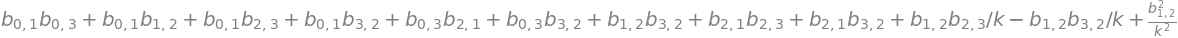

In [15]:
(c1.eval(x))

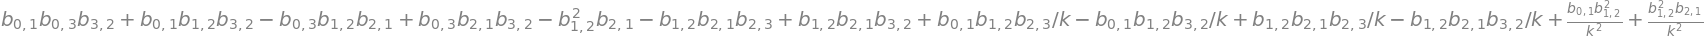

In [16]:
(c0.eval(x))

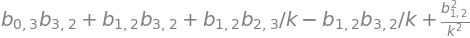

In [17]:
(d0.eval((x[1],x[2],x[4],x[5])))

In [62]:
p = parametersFromEdges([[2],[0,1,3],[2,0]])
p

In [63]:
J = modelJacobian(p,c) 
J

⎡                         1                                           1       
⎢                                                                             
⎢       a[0, 2] + a[0, 3] + a[2, 3] + a[3, 2]            a[0, 3] + a[2, 1] + a
⎢                                                                             
⎢a[0, 2]⋅a[0, 3] + a[0, 2]⋅a[2, 3] + a[0, 3]⋅a[3, 2]  a[0, 3]⋅a[2, 1] + a[2, 1
⎢                                                                             
⎢                         0                                           1       
⎢                                                                             
⎣                         0                                   a[0, 3] + a[2, 3

                   1                  1                       1               
                                                                              
[2, 3]     a[0, 3] + a[2, 3]  a[0, 3] + a[2, 1]  a[0, 2] + a[1, 2] + a[2, 1]  
                                                   

In [64]:
J.rank()

In [69]:
newJ = J.col_join(Matrix([[0,0,1,0,0,0]]))
newJ

⎡                         1                                           1       
⎢                                                                             
⎢       a[0, 2] + a[0, 3] + a[2, 3] + a[3, 2]            a[0, 3] + a[2, 1] + a
⎢                                                                             
⎢a[0, 2]⋅a[0, 3] + a[0, 2]⋅a[2, 3] + a[0, 3]⋅a[3, 2]  a[0, 3]⋅a[2, 1] + a[2, 1
⎢                                                                             
⎢                         0                                           1       
⎢                                                                             
⎢                         0                                   a[0, 3] + a[2, 3
⎢                                                                             
⎣                         0                                           0       

                   1                  1                       1               
                                                   

In [70]:
newJ.rank()

In [25]:
det(J[:,[0,1,2,3,4]]) #excluding da23/dt column

In [26]:
det(J[:,[0,1,2,3,5]]) #excluding da02/dt column

In [27]:
det(J[:,[0,1,2,4,5]]) #excluding da32/d2 column

In [28]:
det(J[:,[0,1,3,4,5]]) #excluding da12/dt column

In [29]:
det(J[:,[0,2,3,4,5]]) #excluding da01/dt column

In [30]:
det(J[:,[1,2,3,4,5]]) #excluding da21/dt column

The Jacobian minors that are zero are the ones where I exclude the column where I take the derivative with respect to $a_{2,3}$ or $a_{3,2}$.

## BELOW IS FOO

Example below here is Model 1 from homework sheet.

In [ ]:
p = parametersFromEdges([[0,2],[0,1,3],[2]])
p

In [ ]:
A = compartmentalMatrix([[0,2],[0,1,3],[2]])
A

In [ ]:
c = inputOutput(A,1,2,1,1)
c

In [ ]:
J = modelJacobian(p,c)
J

In [ ]:
J.rank() == J.shape[1]

In [10]:
A = compartmentalMatrix([[2],[1,0,3],[2,4],[0,3]])
A

⎡-a[2, 1]            a[1, 2]                     0                   0        
⎢                                                                             
⎢a[2, 1]   -a[0, 2] - a[1, 2] - a[3, 2]       a[2, 3]                0        
⎢                                                                             
⎢   0                a[3, 2]             -a[2, 3] - a[4, 3]       a[3, 4]     
⎢                                                                             
⎣   0                   0                     a[4, 3]        -a[0, 4] - a[3, 4

 ⎤
 ⎥
 ⎥
 ⎥
 ⎥
 ⎥
]⎦

In [11]:
c = inputOutput(A,1,1,0,1)
c

In [12]:
p = parametersFromEdges([[2],[1,0,3],[2,4],[0,3]])
p

In [13]:
J = modelJacobian(p,c)
J

⎡                                                                             
⎢                                                                             
⎢                                                            a[0, 2] + a[0, 4]
⎢                                                                             
⎢a[0, 2]⋅a[0, 4] + a[0, 2]⋅a[2, 3] + a[0, 2]⋅a[3, 4] + a[0, 2]⋅a[4, 3] + a[0, 
⎢                                                                             
⎢                                      a[0, 2]⋅a[0, 4]⋅a[2, 3] + a[0, 2]⋅a[0, 
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎣                                                   

In [16]:
J.rank()

In [15]:
augmentedJ = J.col_join(Matrix([[1,0,0,0,0,0,0,0]]))
augmentedJ

⎡                                                                             
⎢                                                                             
⎢                                                            a[0, 2] + a[0, 4]
⎢                                                                             
⎢a[0, 2]⋅a[0, 4] + a[0, 2]⋅a[2, 3] + a[0, 2]⋅a[3, 4] + a[0, 2]⋅a[4, 3] + a[0, 
⎢                                                                             
⎢                                      a[0, 2]⋅a[0, 4]⋅a[2, 3] + a[0, 2]⋅a[0, 
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                   

In [17]:
augmentedJ.rank()

Bad pipe message: %s [b'\xf4\xc0\xf4\xa8\xf0S;\xfa\x0bEH\xe7XJ)\xcb\xa0\xa7 \n\xa9\xf4=\xa9R\x85\x8ai\x02\x18\x83\xed\xd8\xcf\xd2\xcf\xf0l\x991\x1a']
Bad pipe message: %s [b'\xaa\xb6S\x89\x0c\x1ca]\xd0\xd4\x7f\xd3q\xabw\x8d\n\x9a \x10\x8eMC&']
Bad pipe message: %s [b'\xc9\x1ep\xf4\xe6^_;\xd0=}P\x06\xc2\x0c%r\xc4\x00\x00|\xc0,\xc00\x00\xa3\x00\x9f\xcc\xa9\xcc\xa8\xcc']
Bad pipe message: %s [b"\xf3\x0bF?\xfaD\xf0\xd6\x08\xa5\xd5\xfe\xde\x95d\xcc\xa4\x99\x00\x00\xa6\xc0,\xc00\x00\xa3\x00\x9f\xcc\xa9\xcc\xa8\xcc\xaa\xc0\xaf\xc0\xad\xc0\xa3\xc0\x9f\xc0]\xc0a\xc0W\xc0S\xc0+\xc0/\x00\xa2\x00\x9e\xc0\xae\xc0\xac\xc0\xa2\xc0\x9e\xc0\\\xc0`\xc0V\xc0R\xc0$\xc0(\x00k\x00j\xc0s\xc0w\x00\xc4\x00\xc3\xc0#\xc0'\x00g\x00@\xc0r\xc0v\x00\xbe\x00\xbd\xc0\n\xc0\x14\x009\x008\x00\x88\x00\x87\xc0"]
Bad pipe message: %s [b">\x9d\x12L\x0f\xea\xc9\x8b\xd0O\xa8\x0f{\xfa\xb3\xcc\xff\x1e\x00\x00\xf4\xc00\xc0,\xc0(\xc0$\xc0\x14\xc0\n\x00\xa5\x00\xa3\x00\xa1\x00\x9f\x00k\x00j\x00i\x00h\x009\x008\x007\x006\x00\x88\x0